In [1]:
'''
train_path = '/kaggle/input/tempdata1'

# save all files to kaggle/files/images
path = '/kaggle/working/images'

from zipfile import ZipFile as zipper
with zipper(train_path, 'r') as zipp:
    zipp.extractall(destination)
    
with zipper(test_path, 'r') as zipp:
    zipp.extractall(destination)import os
'''

import torch
import torchvision.models
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt 

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

transform = transforms.Compose([
    transforms.Resize([96, 180]),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()    
])

def f(t):
    return torch.tensor([t]).float()

Using cuda device


In [2]:
path = '/kaggle/input/chinafutureohlc/train/60'
ds = datasets.ImageFolder(path, transform = transform, target_transform= f)

print(ds.class_to_idx)

from torch.utils.data import random_split

ds_train, ds_valid = random_split(
    dataset=ds,
    lengths=[.7, .3],
    generator=torch.Generator().manual_seed(0)
)

dl = DataLoader(ds,batch_size = 64,shuffle = True,num_workers=2)

dl_train = DataLoader(ds_train,batch_size = 64,shuffle = True,num_workers=2)
dl_valid = DataLoader(ds_valid,batch_size = 64,shuffle = True,num_workers=2)


{'0': 0, '1': 1}


torch.Size([64, 1, 96, 180])
torch.Size([64, 1])


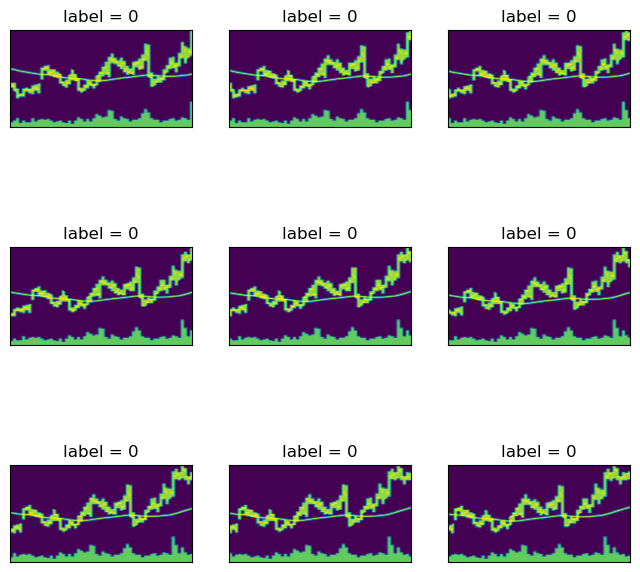

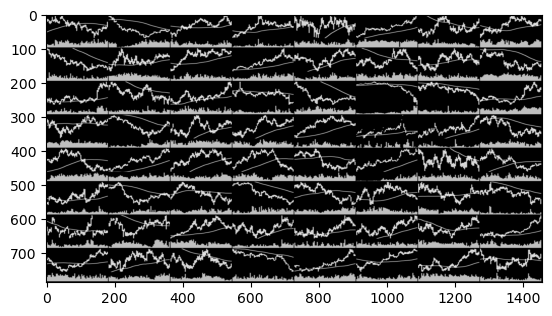

In [3]:
for features,labels in dl:
    print(features.shape)
    print(labels.shape)
    break

plt.figure(figsize=(8,8)) 
for i in range(1,10):
    img,label = ds[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

for i, data in enumerate(dl):
    images, labels = data

    img = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
 
    break

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnnStack = nn.Sequential(
            nn.Conv2d(1, 64, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),
            
            nn.Conv2d(128, 256, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),
            
            nn.Conv2d(256, 512, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),

            nn.Flatten(),
            nn.Linear(552960, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.cnnStack(x)

model = NeuralNetwork().to(device)

In [5]:
def two_hot(y):
    label = []
    for i in range(len(y)):
        if y[i]==1:
            label.append([1,0])
        else:
            label.append([0,1])
    return torch.Tensor(label).to(device)
    
loss_fn = nn.CrossEntropyLoss()
def train(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = two_hot(y)
        pred = model(X)
        #print(pred,y)
        loss = loss_fn(pred, y)
        #print(loss)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        '''
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        '''
    return loss.item()

In [6]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y = two_hot(y)
            test_loss += loss_fn(pred, y)
            pred = pred[:,0].ge(0.5)
            y = y[:,0].le(0.5)
            #print(pred,y)
            correct += (pred == y).sum().item()
            
    test_loss /= len(dataloader.dataset)
    #print(f"Average Loss: {test_loss:>7f} Accuracy: {int(correct / len(dataloader.dataset) * 100)}%")
    return test_loss.item(), correct / len(dataloader.dataset)

In [7]:
epochs = 1000
result = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    if(t<30):
        lr = 0.01
    else:
        lr = (epochs-t)/epochs*0.1
    
    optimizer = torch.optim.ASGD(model.parameters(), lr = lr)
    train_loss = train(dl_train, model, loss_fn, optimizer)
    test_loss, curr = test(dl_valid, model, loss_fn)
    print([t, lr, train_loss, test_loss, curr])
    result.append([t, lr, train_loss, test_loss, curr])

    if(t%10 == 0):
        torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, '/kaggle/working/chkpt'+str(t)+'.pt')
        torch.save(result,'/kaggle/working/result'+str(t)+'.pt')

print("Done!")

[0, 0.01, 0.6862754821777344, 0.01075076311826706, 0.44400199104031857]


[1, 0.01, 0.6828309893608093, 0.01073871087282896, 0.44215316788736403]


[2, 0.01, 0.6769244074821472, 0.01069185882806778, 0.4401621275687976]


[3, 0.01, 0.6941168308258057, 0.010676560923457146, 0.433193486453815]


[4, 0.01, 0.6867187023162842, 0.01068531908094883, 0.4458508141932731]


[5, 0.01, 0.653590202331543, 0.010735069401562214, 0.4417976249733343]


[6, 0.01, 0.6469458341598511, 0.01064648199826479, 0.426722605418474]


[7, 0.01, 0.650386393070221, 0.010611210949718952, 0.4227405247813411]


[8, 0.01, 0.6668375134468079, 0.010702159255743027, 0.4474863115978099]


[9, 0.01, 0.6300967335700989, 0.010589213110506535, 0.42181611320486384]


[10, 0.01, 0.6543292999267578, 0.010525395162403584, 0.41932731280665575]


[11, 0.01, 0.6640485525131226, 0.01051818486303091, 0.4160563179975823]


[12, 0.01, 0.6466159224510193, 0.010487277992069721, 0.4083054824717343]


[13, 0.01, 0.6449967622756958, 0.010681160725653172, 0.4235938277750124]


[14, 0.01, 0.6796715259552002, 0.010449456050992012, 0.4051767048282728]


[15, 0.01, 0.6996996402740479, 0.010319204069674015, 0.3886795136172936]


[16, 0.01, 0.5811185240745544, 0.010335993953049183, 0.39003057669060653]


[17, 0.01, 0.6175147891044617, 0.010300981812179089, 0.3877551020408163]


[18, 0.01, 0.5741053223609924, 0.010266252793371677, 0.38135532958828133]


[19, 0.01, 0.5903506875038147, 0.010311491787433624, 0.38448410723174287]


[20, 0.01, 0.6388406753540039, 0.010278673842549324, 0.3802175922633862]


[21, 0.01, 0.5672990083694458, 0.010182952508330345, 0.37047571641897176]


[22, 0.01, 0.5520908832550049, 0.010287882760167122, 0.3806442437602219]


[23, 0.01, 0.5681320428848267, 0.010186404921114445, 0.37012017350494203]


[24, 0.01, 0.5113204121589661, 0.010325233452022076, 0.38363080423807155]


[25, 0.01, 0.5973820090293884, 0.010382880456745625, 0.38270639266159423]


[26, 0.01, 0.5761832594871521, 0.009970315732061863, 0.350920856147337]


[27, 0.01, 0.5787198543548584, 0.009933163411915302, 0.3498542274052478]


[28, 0.01, 0.5847743153572083, 0.010021413676440716, 0.3546185024532461]


[29, 0.01, 0.613272488117218, 0.010152309201657772, 0.36919576192846476]


[30, 0.097, 0.6534886360168457, 0.011888380162417889, 0.46021474792007394]


[31, 0.0969, 0.5900351405143738, 0.010741344653069973, 0.42010950721752116]


[32, 0.0968, 0.5934308767318726, 0.010307742282748222, 0.38142643817108723]


[33, 0.09670000000000001, 0.49217042326927185, 0.010098411701619625, 0.3603071890777217]


[34, 0.0966, 0.4856608808040619, 0.00980164110660553, 0.33627248808931237]


[35, 0.0965, 0.5174098014831543, 0.009613092057406902, 0.3216952286140937]


[36, 0.0964, 0.5291696786880493, 0.00956944189965725, 0.31678873640048355]


[37, 0.0963, 0.49135956168174744, 0.009296409785747528, 0.2972338761288488]


[38, 0.09620000000000001, 0.5098514556884766, 0.009275550954043865, 0.29502951006186445]


[39, 0.0961, 0.3970317542552948, 0.009246335364878178, 0.29339401265732773]


[40, 0.096, 0.42813384532928467, 0.009209905751049519, 0.2885586290265235]


[41, 0.0959, 0.46890681982040405, 0.009107256308197975, 0.281447770745929]


[42, 0.0958, 0.38252967596054077, 0.008998106233775616, 0.27341250088885727]


[43, 0.09570000000000001, 0.3756868243217468, 0.008965866640210152, 0.27127924340467896]


[44, 0.0956, 0.44322502613067627, 0.008707854896783829, 0.2538576406172225]


[45, 0.0955, 0.3354223370552063, 0.00877880398184061, 0.2590485671620565]


[46, 0.0954, 0.396356999874115, 0.008843381889164448, 0.2615373675602645]


[47, 0.0953, 0.3258199989795685, 0.008638599887490273, 0.24944890848325393]


[48, 0.0952, 0.34350425004959106, 0.008631184697151184, 0.24738675958188153]


[49, 0.0951, 0.338130384683609, 0.008635485544800758, 0.2498755599800896]


[50, 0.095, 0.3519198000431061, 0.008768589235842228, 0.25684420109507217]


[51, 0.0949, 0.3881781995296478, 0.008712003007531166, 0.2525776861267155]


[52, 0.0948, 0.3443724811077118, 0.008517207577824593, 0.23949370689042168]


[53, 0.0947, 0.33542120456695557, 0.008507292717695236, 0.23928038114200384]


[54, 0.0946, 0.3377344310283661, 0.008523942902684212, 0.24027590130128706]


[55, 0.0945, 0.3337373733520508, 0.008418265730142593, 0.23416056317997583]


[56, 0.0944, 0.35845044255256653, 0.008528762497007847, 0.24077366138092868]


[57, 0.0943, 0.31342920660972595, 0.008439062163233757, 0.23373391168314014]


[58, 0.0942, 0.3834681510925293, 0.008428800851106644, 0.23373391168314014]


[59, 0.0941, 0.3567450940608978, 0.008357791230082512, 0.23024959112564886]


[60, 0.094, 0.31327301263809204, 0.008303502574563026, 0.22598307615729218]


[61, 0.0939, 0.3785659968852997, 0.008337439969182014, 0.2277607907274408]


[62, 0.0938, 0.3134959042072296, 0.008276045322418213, 0.223636492924696]


[63, 0.0937, 0.3351343274116516, 0.008265651762485504, 0.22320984142786035]


[64, 0.09360000000000002, 0.33500832319259644, 0.008222508244216442, 0.22157434402332363]


[65, 0.09350000000000001, 0.33504533767700195, 0.008221450261771679, 0.22150323544051767]


[66, 0.09340000000000001, 0.33500435948371887, 0.008221400901675224, 0.22207210410296524]


[67, 0.09330000000000001, 0.3133060336112976, 0.008231975138187408, 0.22128990969209983]


[68, 0.0932, 0.31368201971054077, 0.008278842084109783, 0.22505866458081492]


[69, 0.09310000000000002, 0.31328192353248596, 0.008233783766627312, 0.22150323544051767]


[70, 0.09300000000000001, 0.3350067138671875, 0.008225945755839348, 0.22022328095001067]


[71, 0.09290000000000001, 0.35676640272140503, 0.008225096389651299, 0.21972552087036906]


[72, 0.09280000000000001, 0.3132782578468323, 0.008223014883697033, 0.21986773803598095]


[73, 0.0927, 0.33501869440078735, 0.008220331743359566, 0.21936997795633933]


[74, 0.09260000000000002, 0.31326788663864136, 0.008229519240558147, 0.222356538434189]


[75, 0.09250000000000001, 0.33502915501594543, 0.008222500793635845, 0.22178766977174144]


[76, 0.09240000000000001, 0.3132776916027069, 0.008222540840506554, 0.22200099552015928]


[77, 0.09230000000000001, 0.31328028440475464, 0.00822075828909874, 0.2224987555998009]


[78, 0.0922, 0.356761634349823, 0.008223066106438637, 0.2218587783545474]


[79, 0.09210000000000002, 0.31328636407852173, 0.008223322220146656, 0.22136101827490579]


[80, 0.09200000000000001, 0.3132805824279785, 0.008224873803555965, 0.22107658394368201]


[81, 0.09190000000000001, 0.313288152217865, 0.00822330079972744, 0.22086325819526417]


[82, 0.0918, 0.37850847840309143, 0.00822473969310522, 0.22178766977174144]


[83, 0.0917, 0.37850481271743774, 0.00822266936302185, 0.22164545260612956]


[84, 0.09160000000000001, 0.3350670039653778, 0.008232658728957176, 0.22228542985138305]


[85, 0.09150000000000001, 0.3132920265197754, 0.008220716379582882, 0.22128990969209983]


[86, 0.09140000000000001, 0.3132930397987366, 0.00822138786315918, 0.22143212685771171]


[87, 0.0913, 0.3350590169429779, 0.008223921060562134, 0.2217165611889355]


[88, 0.0912, 0.3133030831813812, 0.008221939206123352, 0.22079214961245822]


[89, 0.09110000000000001, 0.35677993297576904, 0.008227069862186909, 0.22271208134821874]


[90, 0.09100000000000001, 0.31328973174095154, 0.008231659419834614, 0.2218587783545474]


[91, 0.09090000000000001, 0.3350822329521179, 0.008227727375924587, 0.2224987555998009]


[92, 0.0908, 0.3133131265640259, 0.00822928175330162, 0.22306762426224847]


[93, 0.0907, 0.3350585401058197, 0.008231619372963905, 0.22306762426224847]
